# Librerias y Preparacion

In [ ]:
import os
import time
import shutil
import pandas as pd
from tqdm import tqdm
import tarfile
import random
import os
import pandas as pd
import numpy as np
from PIL import Image
from joblib import Parallel, delayed
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt


Para descargar el dataset de PlantVillage, necesitamos un token de la API de Kaggle
Para ejecutarlo localmente:

    pip install kaggle

    Ve a: https://www.kaggle.com/settings

    Haz clic en “Create New API Token”. Esto descargará un archivo llamado kaggle.json.

Para agregar la API en un lugar seguro en sistemas MAC o Linux:

mkdir -p ~/.kaggle
mv /ruta/del/archivo/kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json

Para Windows:

mkdir %USERPROFILE%\.kaggle
move "C:\ruta\a\kaggle.json" "%USERPROFILE%\.kaggle\"




This is done in colab so if you are running it locally, ignore the #from google colab import files code line

## Cargar token de kaggle descargado

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"axlsaalss","key":"302aa7324809b53d3a3687a5b15b28bd"}'}

In [25]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

This code line will download de .zip file and unzip it.

In [26]:
!kaggle datasets download -d emmarex/plantdisease
!unzip -q plantdisease.zip -d plantvillage

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
plantdisease.zip: Skipping, found more recently modified local copy (use --force to force download)
replace plantvillage/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [27]:
source_dir = "plantvillage/PlantVillage"
classes = os.listdir(source_dir)
print(f"{len(classes)} clases encontradas.")
print("Ejemplos:", classes[:5])

15 clases encontradas.
Ejemplos: ['Tomato_Late_blight', 'Potato___Late_blight', 'Potato___Early_blight', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Septoria_leaf_spot']


The Dataset will download in different files depending on the plant/vegetable, this DF can be use to train, but for testing purposes, the next code will create a flat dataset that contains all the images.

## Ruta del dataset plano (ya aplanado con las imágenes en una carpeta y su labels.csv)

In [36]:
dest_dir = "flat_dataset_PlantVillage"
os.makedirs(dest_dir, exist_ok=True)

records = []
counter = 0

for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)

    if not os.path.isdir(class_path):
        continue

    for img_file in os.listdir(class_path):
        src = os.path.join(class_path, img_file)

        if os.path.isdir(src):
            continue

        new_filename = f"image_{counter:05d}.jpg"
        dst = os.path.join(dest_dir, new_filename)

        shutil.copy2(src, dst)
        records.append([new_filename, class_name])
        counter += 1

df = pd.DataFrame(records, columns=["filename", "label"])
df.to_csv(os.path.join(dest_dir, "labels.csv"), index=False)

print(f"Copied {counter} images to '{dest_dir}' and saved labels to 'labels.csv'")



Copied 20639 images to 'flat_dataset_PlantVillage' and saved labels to 'labels.csv'


In [37]:
# Rutas completas
folder1 = "plantvillage/PlantVillage"
#folder2 = "plantvillage/plantvillage/PlantVillage"

print("Clases en PlantVillage:", len(os.listdir(folder1)))
#print("Clases en plantvillage:", len(os.listdir(folder2)))

def contar_imagenes(folder):
    total = 0
    for clase in os.listdir(folder):
        clase_path = os.path.join(folder, clase)
        if os.path.isdir(clase_path):
            total += len(os.listdir(clase_path))
    return total

print("Imágenes en PlantVillage:", contar_imagenes(folder1))
#print("Imágenes en plantvillage:", contar_imagenes(folder2))
print("Clases en PlantVillage:", sorted(os.listdir(folder1))[:5])
#print("Clases en plantvillage:", sorted(os.listdir(folder2))[:5])


Clases en PlantVillage: 15
Imágenes en PlantVillage: 20639
Clases en PlantVillage: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [38]:
!rm -rf plantvillage/plantvillage



## 1, 2. CONFIG Y NORMALIZACION

In [31]:
# === CONFIGURACIÓN ===
dataset_dir = "flat_dataset_PlantVillage"
labels_path = os.path.join(dataset_dir, "labels.csv")
image_size = (128, 128)  # Tamaño al que redimensionaremos todas las imágenes


# Cargamos el archivo labels.csv, que contiene la columna 'filename' y 'label'
df = pd.read_csv(labels_path)
print("Total imágenes:", len(df))
print(df.head())

# Esta función abre una imagen individual, la convierte a RGB, la redimensiona al tamaño estándar
# y la normaliza dividiendo por 255.0 para que los valores estén entre 0 y 1.
def load_and_preprocess_image(filename):
    try:
        path = os.path.join(dataset_dir, filename)
        img = Image.open(path).convert("RGB")
        img = img.resize(image_size)
        arr = np.array(img) / 255.0  # Normalizamos los valores de píxel
        return arr
    except Exception as e:
        print(f"Error con {filename}: {e}")
        return None




Total imágenes: 20639
          filename               label
0  image_00000.jpg  Tomato_Late_blight
1  image_00001.jpg  Tomato_Late_blight
2  image_00002.jpg  Tomato_Late_blight
3  image_00003.jpg  Tomato_Late_blight
4  image_00004.jpg  Tomato_Late_blight


# Comparacion Paralelismo/Secuencial

## Paralela

### 3. CARGAR TODAS LAS IMÁGENES CON JOBLIB

In [33]:
start = time.time()

images_parallel = Parallel(n_jobs=-1)(
    delayed(load_and_preprocess_image)(fname) for fname in df["filename"]
)

print(f"Tiempo con Joblib: {time.time() - start:.2f} segundos")

Tiempo con Joblib: 17.91 segundos


Aquí usamos Joblib para cargar las imágenes en paralelo, utilizando múltiples núcleos del CPU.
'Parallel(n_jobs=-1)' le dice a Joblib que use todos los núcleos disponibles.
'delayed(...)' permite que la función se ejecute de forma diferida y distribuida.

¿Qué hace Joblib aquí?

    Acelera el proceso de carga y preprocesamiento de imágenes.

    En lugar de cargar las 20,000 imágenes secuencialmente (una por una), las distribuye entre varios núcleos.

    Esto reduce drásticamente el tiempo de espera cuando trabajas con datasets grandes.

### 4. ELIMINAR ERRORES

Eliminamos imágenes que no pudieron ser cargadas (por errores o archivos dañados).
Asociamos correctamente cada imagen con su etiqueta correspondiente.

In [35]:
valid_data = [(img, label) for img, label in zip(images_parallel, df["label"]) if img is not None]
X, y = zip(*valid_data) # Separamos los datos en X (imágenes) e y (etiquetas)
X = np.stack(X)
print("Shape de X:", X.shape)  # Convertimos la lista de arrays en un solo array multidimensional

# === 5. CONVERTIR ETIQUETAS A NÚMEROS Y CATEGORÍAS ===
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)
print("Shape de y:", y_categorical.shape)
print("Clases:", label_encoder.classes_)

Shape de X: (20638, 128, 128, 3)
Shape de y: (20638, 15)
Clases: ['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


## Secuencial (SOPHIA)

In [39]:
# Cargar las imágenes de manera secuencial
start = time.time()

images_sequential = []
for fname in df["filename"]:
    img = load_and_preprocess_image(fname)
    images_sequential.append(img)

print(f"Tiempo secuencial: {time.time() - start:.2f} segundos")

Error con image_18720.jpg: cannot identify image file 'flat_dataset_PlantVillage/image_18720.jpg'
Tiempo secuencial: 34.25 segundos


In [41]:
# Limpieza de datos no válidos

label_encoder = LabelEncoder()
label_encoder.fit(df["label"])

valid_data_seq = [(img, label) for img, label in zip(images_sequential, df["label"]) if img is not None]

# Separar en X e y
X_seq, y_seq = zip(*valid_data_seq)
X_seq = np.stack(X_seq)

print("Shape secuencial de X:", X_seq.shape)

# Convertir etiquetas
y_seq_encoded = label_encoder.transform(y_seq)
y_seq_categorical = to_categorical(y_seq_encoded)

# Verificación
print("Shape secuencial de y:", y_seq_categorical.shape)

print("Clases:", label_encoder.classes_)

Shape secuencial de X: (20638, 128, 128, 3)
Shape secuencial de y: (20638, 15)
Clases: ['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


# 5. CCN MODEL


Dividimos los datos en 80% entrenamiento y 20% prueba.
'stratify=y_categorical' asegura que las clases estén balanceadas en ambos grupos.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, stratify=y_categorical, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (16510, 128, 128, 3) Test: (4128, 128, 128, 3)


Creamos un modelo secuencial de Keras (estructura básica de una CNN)

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(y_categorical.shape[1], activation='softmax')  # salida según número de clases
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Compilamos el modelo con:
 - optimizador Adam
 - función de pérdida para clasificación multiclase: categorical_crossentropy
 - métrica de evaluación: precisión (accuracy)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Entrenamos el modelo usando los datos de entrenamiento.
'validation_split=0.1' toma el 10% de los datos de entrenamiento para validación interna.

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1
)


Epoch 1/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.4174 - loss: 1.8936 - val_accuracy: 0.7492 - val_loss: 0.7586
Epoch 2/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7968 - loss: 0.6247 - val_accuracy: 0.8177 - val_loss: 0.5589
Epoch 3/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8761 - loss: 0.3700 - val_accuracy: 0.8661 - val_loss: 0.3949
Epoch 4/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9073 - loss: 0.2799 - val_accuracy: 0.8546 - val_loss: 0.4380
Epoch 5/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9480 - loss: 0.1564 - val_accuracy: 0.8680 - val_loss: 0.4248
Epoch 6/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9614 - loss: 0.1138 - val_accuracy: 0.8546 - val_loss: 0.4825
Epoch 7/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9702 - loss: 0.0882 - val_accuracy: 0.8764 - val_loss: 0.4213
Epoch 8/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9704 - loss: 0.0869 - val_accuracy: 

Evaluamos la precisión final del modelo usando el 20% de datos reservados para prueba.

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")




129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8819 - loss: 0.5393
Test Accuracy: 0.8876


**Visualizar el entrenamiento**

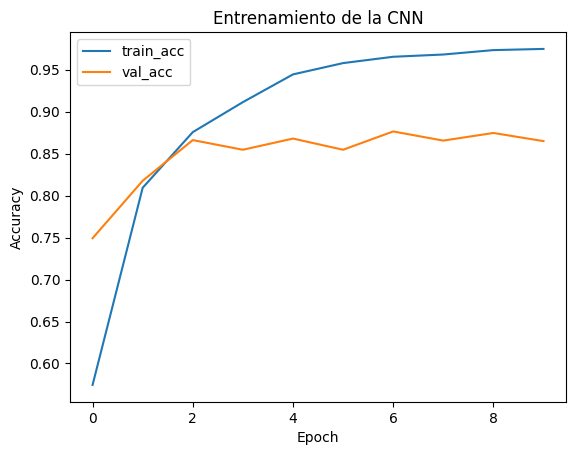

In [ ]:

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Entrenamiento de la CNN")
plt.show()


### El gráfico muestra que la precisión del modelo en el conjunto de entrenamiento aumenta rápidamente desde aproximadamente 58% hasta casi 99% en solo 10 épocas, lo que indica que la CNN aprende muy bien los datos que ha visto. Sin embargo, la precisión en el conjunto de validación se estabiliza entre 86% y 88% a partir de la tercera época, sin mejorar significativamente. Esta diferencia sugiere que el modelo está sobreajustando ligeramente: memoriza los datos de entrenamiento pero no generaliza con la misma efectividad a datos nuevos. A pesar de ello, alcanzar cerca del 87% de precisión en validación es un muy buen resultado inicial para este tipo de modelo.



## **Guardar modelo**

In [ ]:

model.save("plantvillage_cnn_parl.h5")

## **Uso de Joblib en este Dataset y model:**

**Tiempo con Joblib y Paralelismo: 17.91 segundos**

**Tiempo sin Joblib y Secuencial: 34.25 segundos**

## ¿Qué hizo Joblib?

    Distribuyó la función load_and_preprocess_image() (abrir, redimensionar y normalizar cada imagen) en varios núcleos del CPU al mismo tiempo.

    Gracias a n_jobs=-1, usó todos los núcleos disponibles, logrando una ejecución mucho más rápida comparada con un bucle for tradicional.


## ¿Para qué Paralelismo?

    Para cargar más de 20,000 imágenes de forma eficiente.

    Evitar cuellos de botella por lectura secuencial.

    Mejorar el rendimiento del preprocesamiento, que es una etapa costosa en visión por computadora.